In [204]:
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import geojson
import pickle
import json
import re

plt.rcParams.update({'font.size': 8})

In [205]:
from shapely.geometry.polygon import Polygon
from shapely.geometry import Point,shape

In [206]:
def open_file(name):
    with open(name, 'rb') as f:
        book_storage = pickle.load(f)
    return book_storage

In [207]:
def preproc2(line):
    '''
    переделать
    '''
    line = re.sub('ё', 'е', line)
    line = re.sub('(?:\[.+?\]|\(.+?\)|\xa0|\n)', '', line)
    line = re.sub('—|–', '-', line)
    line = re.sub(' ?- ?', '-', line)
    line = re.sub(' +', ' ', line)
    line = re.sub('(?:^ | $)', '', line)
    line = re.sub('(?:\-(Югра|Алания|Чувашия|Кузбасс)| МР)', '', line)
    line = re.sub('(?: г|Г)ород федерального значения ?', '', line)
    line = re.sub(' столица Российской Федерации', '', line)
    line = re.sub('Город ', '', line)
    line = re.sub('\*', '', line)
    line = re.sub(' (?:Republic|Oblast)', '', line)
    return line

In [208]:
plot_path = "/Users/Stoneberry/Desktop/papers/master/stat/"

def myplot(x, y, title, xname, yname, name=False, rotation=45,
           type_='bar', label=None, text = False):
   
    global plot_path
        
    fig = plt.figure(figsize = (18, 8))
    ax = fig.gca()
    
    if type_ == 'scatter':
        plt.scatter(x, y, color = 'skyblue', label=label)
    
    else:
        plt.bar(x, y, color = 'skyblue')
        plt.xticks(rotation = rotation) #rotation='vertical')
        
    if text:
        for index, item in enumerate(zip(x, y)):
            plt.annotate(text[index], # this is the text
                         item, # this is the point to label
                         textcoords="offset points", # how to position the text
                         xytext=(0,10), # distance from text to points (x,y)
                         ha='center')
    
    plt.xlabel(xname)
    plt.ylabel(yname)
    plt.title(title)
    
    ax.set_axisbelow(True)
    ax.yaxis.grid(color='gainsboro', linestyle='dashed')
    ax.xaxis.grid(color='gainsboro', linestyle='dashed')
    
    if name:
        plt.savefig(plot_path + name + ".svg", format='svg', dpi=1200)

In [209]:
region_info = pd.read_csv('/Users/Stoneberry/Desktop/papers/master/regions/region_data2.csv', sep=';')
region_info['geoname_name'] = region_info['geoname_name'].apply(preproc2)

with open('/Users/Stoneberry/Desktop/papers/master/regions/russia.json') as f:
    gj = json.load(f)

In [210]:
reg_coord = {}

for region in gj['features']:
    name = re.sub("'", "", region['properties']['NAME_1'])
    ind = region_info[region_info['geoname_name'] == name].index.values[0]
    name = region_info['name'][ind]
    reg_coord[name] = region['geometry']#['coordinates']

In [211]:
regions = {region: shape(reg_coord[region]) for region in reg_coord.keys()}

In [212]:
regions.keys()

dict_keys(['Карачаево-Черкесская', 'Карелия', 'Кемеровская', 'Хабаровский', 'Хакасия', 'Ханты-Мансийский', 'Кировская', 'Коми', 'Костромская', 'Краснодарский', 'Адыгея', 'Алтайский', 'Амурская', 'Архангельская', 'Астраханская', 'Башкортостан', 'Белгородская', 'Брянская', 'Бурятия', 'Чеченская', 'Челябинская', 'Чукотский', 'Чувашская', 'Санкт-Петербург', 'Дагестан', 'Алтай', 'Ингушетия', 'Ивановская', 'Кабардино-Балкарская', 'Калининградская', 'Калмыкия', 'Калужская', 'Курганская', 'Курская', 'Ленинградская', 'Липецкая', 'Магаданская', 'Марий Эл', 'Мордовия', 'Москва', 'Московская', 'Мурманская', 'Ненецкий', 'Нижегородская', 'Северная Осетия', 'Новгородская', 'Новосибирская', 'Омская', 'Орловская', 'Оренбургская', 'Пензенская', 'Приморский', 'Псковская', 'Ростовская', 'Рязанская', 'Якутия', 'Сахалинская', 'Самарская', 'Саратовская', 'Смоленская', 'Ставропольский', 'Свердловская', 'Тамбовская', 'Татарстан', 'Томская', 'Тульская', 'Тыва', 'Тверская', 'Тюменская', 'Удмуртская', 'Ульяновска

## Определяем регионы библиотек

In [213]:
data = pd.read_csv("/Users/Stoneberry/Desktop/papers/master/database.csv", sep=",")
data.head()

,Название,Местоположение,Часовой пояс,Улица,Примечание,Адрес,На карте,Описание,Адрес сайта,Адрес электронной почты,...,Types[],Start,ID места ЕИПСК,ServiceName,ЕИПСК,Культура.РФ,Госкаталог,Статистика,Дата создания записи,Дата последнего обновления записи
0,Аксёновская сельская библиотека-филиал № 4,Галичский район,Europe/Moscow,"д. Аксёново, 24",NaN,NaN,"{""coordinates"":[42.50301500000001,58.309780999...","<p style=""text-align:left""><span>Библиотека ос...",NaN,biblioteka-gorkogo.galich@yandex.ru,...,NaN,NaN,25431,"[{""serviceName"":""Культура.рф""}]",NaN,NaN,NaN,NaN,2016-10-20T07:48:12Z,2016-10-24T14:07:12Z
1,Мелёшинская сельская библиотека-филиал № 15,Галичский район,Europe/Moscow,"д. Мелёшино, ул. Центральная, 16",NaN,NaN,"{""coordinates"":[42.54122,58.438008],""type"":""Po...","<p style=""text-align:left""><span> Библиотека о...",NaN,biblioteka-gorkogo.galich@yandex.ru,...,NaN,NaN,25427,"[{""serviceName"":""Культура.рф""},{""serviceName"":...",NaN,NaN,NaN,NaN,2016-10-20T06:05:30Z,2016-10-24T13:57:48Z
2,Ряжская центральная библиотека,Ряжский район,Europe/Moscow,"г. Ряжск, пл. Советская, 11",NaN,NaN,"{""coordinates"":[40.06328100000002,53.708139000...","<p style=""text-align:left""><span>В феврале 186...",http://www.ryajsk-lib.ru,ryagsk-biblioteka2010@yandex.ru,...,NaN,NaN,25410,"[{""serviceName"":""Культура.рф""}]",NaN,NaN,NaN,NaN,2016-10-19T12:24:27Z,2016-10-24T13:17:32Z
3,Левковская сельская библиотека-филиал № 12,Галичский район,Europe/Moscow,"д. Левково, ул. Молодёжная, 1",NaN,NaN,"{""coordinates"":[42.187105,58.552082999999996],...","<p style=""text-align:left""><span>Левковская се...",NaN,biblioteka-gorkogo.galich@yandex.ru,...,NaN,NaN,25388,"[{""serviceName"":""Культура.рф""}]",NaN,NaN,NaN,NaN,2016-10-19T07:51:11Z,2016-10-24T12:54:32Z
4,Сасовская центральная библиотека,Сасово,Europe/Moscow,"ул. Ленина, 40",NaN,NaN,"{""coordinates"":[41.91434900000001,54.341094999...","<p style=""text-align:left""><span><span>Сасовск...",NaN,foliant@pochtamt.ru,...,NaN,NaN,25379,"[{""serviceName"":""Культура.рф""}]",NaN,NaN,NaN,NaN,2016-10-18T14:47:35Z,2016-10-24T12:44:13Z


### wiki

In [214]:
from bs4 import BeautifulSoup
import requests

In [215]:
def get_soup(url):
    req = requests.get(url)
    if req.status_code == 200:
        html = req.text
        soup = BeautifulSoup(html, 'lxml')
        return soup
    return None

def prep_areas(line):
    res = []
    for i in line:
        if line == 'Кашарский МР':
            print(preproc2(i))
        if re.findall("примечания|район", i): continue
        if i == '': continue
        else: res.append(preproc2(i))
    return res


path = 'https://ru.wikipedia.org/wiki/Районы_субъектов_Российской_Федерации'
soup = get_soup(path)

In [216]:
rule = {'Кабардино-Балкария' :'Кабардино-Балкарская',
       'Удмуртия': 'Удмуртская', 'Чечня': 'Чеченская',
       'Чувашия': 'Чувашская',
       'Карачаево-Черкесия': 'Карачаево-Черкесская'}

order = ['республика', 'край', 'область', 'автономная область',
         'автономный округ', 'город федерального значения']

subject = 'республика|край|область|автономная область|автономный округ|город федерального значения|Республика|АО'
subject = re.compile(subject)

In [217]:
place_region = {}
region_area = {}
type_ind = 0

for line in list(soup.find_all('tr'))[1:]:
    
    res = list(line.children)
    
    if len(res) > 3:
        region = subject.sub('', res[1].text)
        region = preproc2(region)
        capital = preproc2(res[5].text).split(' , ')
        areas = prep_areas(res[11].text.split('\n'))

        if region == 'Субъект федерации': 
            type_ind += 1
            continue
        elif type_ind == 0 and region in rule:
            region = rule[region]

        if region == 'Саха': region = 'Якутия'

        for i in capital: place_region[i] = region
        for i in areas: place_region[i] = region
        region_area[region] = areas

## Республика Крым


In [218]:
path = '/Users/Stoneberry/Desktop/papers/master/region stat data/crym.csv'
crym = pd.read_csv(path, sep=';')
crym.head()

,Название,Округ,Население,Координаты
0,Алупка,Ялта,8067,44°24′59″ с. ш. 34°02′40″ в. д.
1,Алушта,Алушта,29 963,44°40′35″ с. ш. 34°24′36″ в. д.
2,Армянск,Армянск,21 552,46°06′21″ с. ш. 33°41′28″ в. д.
3,Бахчисарай,Бахчисарайский,26 572,44°45′05″ с. ш. 33°52′30″ в. д.
4,Белогорск,Белогорский,16 405,45°03′26″ с. ш. 34°36′00″ в. д.


In [219]:
for index in crym.index: 
    for i in ('Название', 'Округ'):
        place_region[crym[i][index]] = 'Крым'

### Определение региона

In [220]:
chan = {'Владивостокский': 'Приморский', 'Чайковский': 'Пермский',
        'Гремячинский': 'Пермский', 'Лысьвенский': 'Пермский',
        'Добрянский': 'Пермский', 'Чусовской': 'Пермский',
        'Гремячинский': 'Пермский', 'Миасский': 'Челябинская',
        'Златоустовский': 'Челябинская', 'Верхнеуфалейский': 'Челябинская',
        'Трехгорный': 'Челябинская', 'Магнитогорский': 'Челябинская',
        'Вуктыльский': 'Коми', 'город-курорт Сочи': 'Краснодарский',
        'город Новороссийск': 'Краснодарский', 'город Северодвинск': 'Архангельская',
        'Вилючинский': 'Камчатский', 'Кизеловский': 'Пермский',
        'Александровск': 'Мурманская', 'Москва': 'Москва'}

for ch in chan: 
    place_region[ch] = chan[ch]

In [221]:
reg1 = ' (?:республика|край|область|(А|о)втономная область|(А|о)втономный округ|город федерального значения|АО|город)'
reg2 = '(?:Республика|Городской округ) '

reg1 = re.compile(reg1)
reg2 = re.compile(reg2)

In [222]:
def detect_region(x, y):
    point = Point([x, y])
    res = False
    for region in regions:
        polygon = regions[region]
        if polygon.contains(point):
            res = region
            break
    return res


def get_region(place, words):
    region = False
    
    if place in regions:
        region = place
    elif place_region.get(place):
        region = place_region[place]
    elif 'район' in place:
        if place == 'Таймырский Долгано-Ненецкий район': 
            reg = 'Таймырский Долгано-Ненецкий' 
        else: 
            ind = words.index('район')
            reg = words[ind-1]
        if place_region.get(reg):
            region = place_region[reg]
    return region

In [223]:
['Респ', 'Марий', ][1:3]

['Марий']

In [224]:
changes = {'Вятско-Полянский район':'Вятскополянский район',
           'Баунтовский эвенкийский район':'Баунтовский район',
           'Шелковской район':'Шелковский район',
           'Владивостокский городской округ':'Владивостокский район',
           'ЗАТО Вилючинск':'Вилючинский район',
           'Нерехта и Нерехтский район':'Нерехтский район'}

def region_detector(data, changes, columns):

    index_reg = []


    for index in data.index:

        for name in columns:
            place = data[name][index]
            if place in changes: place = changes[place]
            #elif 'Городской' in place: place = place.split(' ')[-1]
            for i in (reg1, reg2): place = i.sub('', place)
            place = preproc2(place)
            words = place.split(' ')
            region = get_region(place, words)
            if region: break

        if not region and isinstance(data['Адрес'][index], str):
            place = data['Адрес'][index]
            if place in changes: place = changes[place]
            for i in (reg1, reg2): place = i.sub('', place)
            place = preproc2(place)
            place = place.split(',')[0]
            if re.findall('^респ|обл|край|ао', place.lower()):
                place = place.split(' ')
                region = ' '.join(place[1:])
#             place = place.split(' ')
#             if place.lower() in ('респ', 'обл', 'край', 'ао'):
#                 region = place[1]

        if not region:
            x, y = json.loads(data['На карте'][index])['coordinates']
            region = detect_region(x, y)
            if not region: region = detect_region(y, x)

    #     if not region:
    #         print([index, data['Адрес'][index], data['Местоположение'][index], data['Подчинение'][index]])

        index_reg.append(region)
    return index_reg

In [225]:
index_reg = region_detector(data, changes, ('Подчинение', 'Местоположение'))

In [226]:
region_number = Counter(index_reg)
set(regions.keys()) == set(region_number.keys())

False

In [227]:
len(regions.keys()), len(region_number.keys())

(85, 84)

In [228]:
set(regions.keys()) - set(region_number.keys())

{'Тыва'}

### База Данных

In [191]:
# data = pd.read_csv("/Users/Stoneberry/Desktop/papers/master/data from names/database2.csv", sep=";")

In [229]:
data['Регион'] = index_reg

In [288]:
# data.to_csv("/Users/Stoneberry/Desktop/papers/master/data from names/database2.csv", sep=";")

## Статистика по регионам

In [67]:
reg_num_people = '/Users/Stoneberry/Desktop/papers/master/статистика/csv/Численность_постоянного_населения_в_среднем_за_год.csv'
reg_num_people = pd.read_csv(reg_num_people, sep=';')

In [68]:
# reg_num_people['Название'] = reg_num_people['Название'].apply(preproc2).tolist()

In [103]:
def tune(line):
    line = subject.sub('', line)
#     line = re.sub('-Чувашия', '', line)
    line = preproc2(line)
    if line == 'Саха': line = 'Якутия'
    line = preproc2(line)
    return line

In [70]:
reg_num_people['Название'] = reg_num_people['Название'].apply(tune).tolist()
reg_num_people = reg_num_people[reg_num_people['Название'].isin(region_number.keys())]
reg_num_people = reg_num_people.set_index('Название')

In [71]:
reg_num_people.head()

,N,2010 г.,2011 г.,2012 г.,2013 г.,2014 г.,2015 г.,2016 г.,2017 г.,2018 г.
Название,,,,,,,,,,
Алтайский,1000000000,2424062.0,2412294.0,2402990.0,2394694.0,2387725.0,2380793.0,2371227.0,2357880.0,2341447.0
Амурская,10000000000,831783.0,825116.0,819241.0,814092.0,810573.0,807781.0,803720.0,800088.0,795809.0
Архангельская,11001000000,NaN,NaN,NaN,1154133.0,1144355.0,1135095.0,1126026.0,1116422.0,1105661.0
Астраханская,12000000000,1010461.0,1012386.0,1014406.0,1015178.0,1018902.0,1019956.0,1018746.0,1018190.0,1015790.0
Белгородская,14000000000,1532067.0,1534213.0,1538529.0,1542546.0,1546022.0,1549037.0,1551501.0,1551371.0,1548647.0


####  Density

In [72]:
path = '/Users/Stoneberry/Desktop/papers/master/статистика/density.csv'
region_data = pd.read_csv(path, sep=';')

In [73]:
region_data['Плотность населения чел/км²'] = region_data['Плотность населения чел/км²'].str.replace('\\xa0', '').apply(float)
region_data['Площадь км²'] = region_data['Площадь км²'].str.replace('\\xa0', '').apply(float)
region_data['Население. человек'] = region_data['Население. человек'].str.replace('\\xa0', '').apply(float)

In [74]:
region_data['Название'] = region_data['Субъект России'].apply(tune).tolist()
region_data = region_data[region_data['Название'].isin(region_number.keys())]
region_data = region_data.set_index('Название')

In [75]:
region_data['N_people_2018'] = [reg_num_people['2018 г.'][name] for name in region_data.index]
region_data['N_libr'] = [region_number[name] for name in region_data.index]
region_data['Location'] = [regions[name] for name in region_data.index]

In [76]:
# region_info = region_info[region_info['name'].isin(region_number.keys())]
region_info = region_info.set_index('name')
region_data['federal_district'] = [region_info['federal_district'][name] for name in region_data.index]

In [77]:
# region_data['District'] = [region_area[name] for name in region_data.index]
# region_data['N_district'] = region_data['District'].apply(len)

In [78]:
region_data['N_district']['Москва'] = 125
region_data['N_district']['Санкт-Петербург'] = 18
region_data['N_district']['Севастополь'] = 4

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

In [79]:
region_data.head()

,№,Субъект России,Плотность населения чел/км²,Население. человек,Площадь км²,Фед. округ,N_people_2018,N_libr,Location,federal_district,District,N_district
Название,,,,,,,,,,,,
Москва,1,Москва,4956.06,12692466.0,2561.0,ЦФО,12560873.0,444,"(POLYGON ((37.24789428710932 55.5889129638673,...",Центральный,[],125
Санкт-Петербург,2,Санкт-Петербург,3843.90,5392992.0,1403.0,СЗФО,5367912.0,329,"(POLYGON ((29.71916580200212 59.9754180908206,...",Северо-Западный,"[Адмиралтейский, Василеостровский, Выборгский,...",18
Севастополь,3,Севастополь,519.48,448829.0,864.0,ЮФО,439941.0,24,"POLYGON ((33.66316223144543 44.75286483764648,...",Южный,"[Балаклавский, Гагаринский, Ленинский, Нахимов...",4
Московская,4,Московская область,173.42,7687647.0,44329.0,ЦФО,7551516.0,440,"POLYGON ((37.76903533935564 56.94193267822288,...",Центральный,"[Волоколамский, Воскресенский, Дмитровский, Ег...",36
Ингушетия,5,Республика Ингушетия,162.24,506688.0,3123.0,СКФО,492718.0,2,"POLYGON ((44.89275360107422 43.54350662231451,...",Северо-Кавказский,"[Джейрахский, Малгобекский, Назрановский, Сунж...",4


In [80]:
# with open('/Users/Stoneberry/Desktop/papers/master/region stat data/reg_stat_data.pickle', 'wb') as f:
#     pickle.dump(region_data, f)

### Где нет ни одной библиотеки

In [81]:
set(region_borders.keys()) - set(region_index.keys()) 

NameError: name 'region_borders' is not defined

# Визуализации

#### Кол-во библиотек по регионам

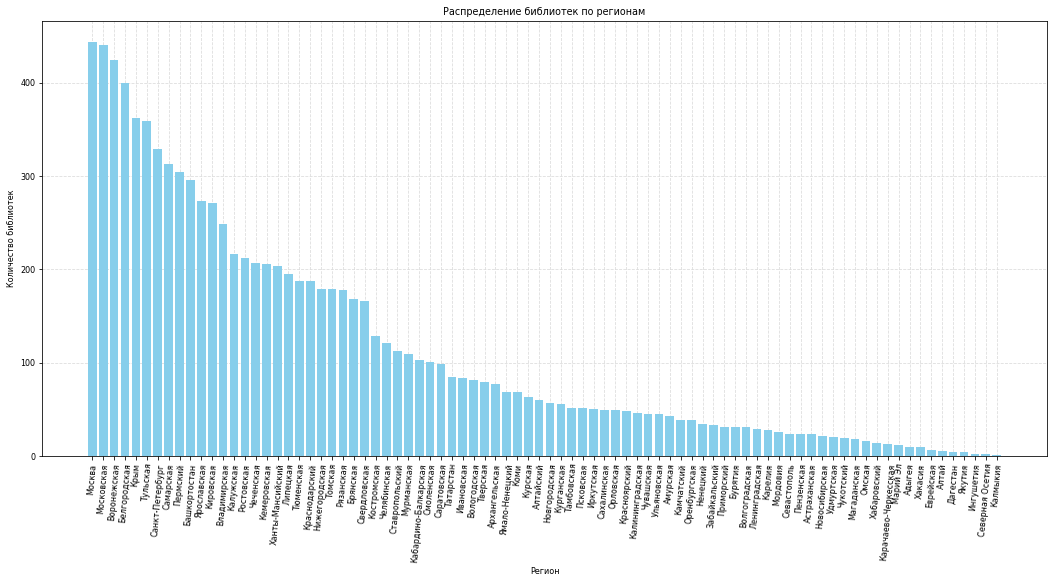

In [82]:
res = {}

for name, value in sorted(region_number.items(), key=lambda kv: kv[1], reverse=True):
#     name = subject.sub('', name)
    res[name] = value

myplot(res.keys(), res.values(),
       'Распределение библиотек по регионам', 
       'Регион', 'Количество библиотек', rotation=85,
        name = 'regions')

#### Кол-во библиотек по федеральным районам

In [83]:
df = region_data[['federal_district', 'N_libr', 'Население. человек', 
                  'Площадь км²', 'Плотность населения чел/км²', 'N_district']]
df = df.groupby('federal_district').sum()

In [84]:
df["Rang from center"] = ['Вост_4', 'Вост_1', 'Сев_1', 'Юг_2', 'Вост_3', 'Вост_2', 'Центр_0', 'Юг_1']

In [85]:
df

,N_libr,Население. человек,Площадь км²,Плотность населения чел/км²,N_district,Rang from center
federal_district,,,,,,
Дальневосточный,287,8167359.0,6952555.0,31.95,194,Вост_4
Приволжский,1758,29286448.0,1036975.0,477.94,447,Вост_1
Северо-Западный,909,14021384.0,1863782.0,3976.12,176,Сев_1
Северо-Кавказский,443,9928721.0,170452.0,547.35,116,Юг_2
Сибирский,594,16791702.0,4193123.0,89.72,252,Вост_3
Уральский,804,14578634.0,3122548.0,79.32,119,Вост_2
Центральный,3901,39439493.0,650205.0,5699.18,544,Центр_0
Южный,850,16466173.0,447821.0,815.26,163,Юг_1


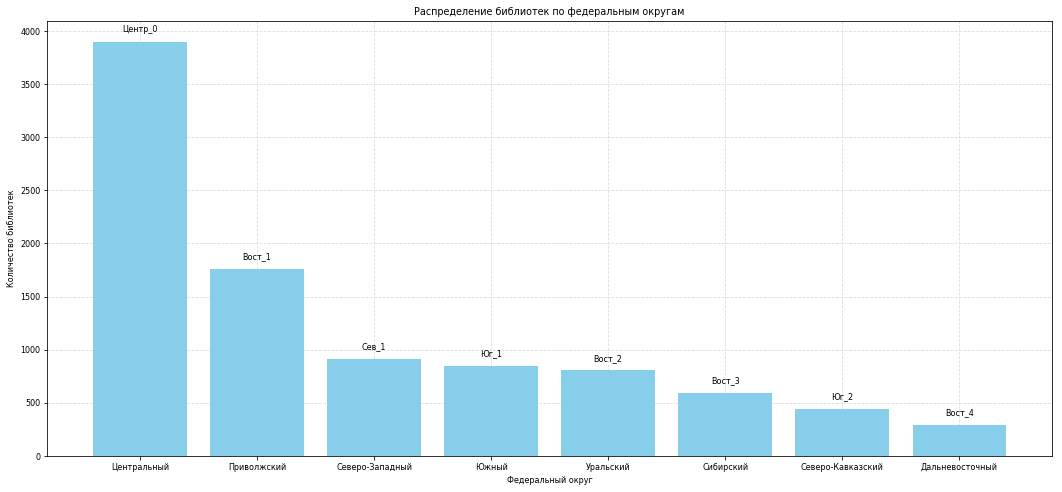

In [86]:
df = df.sort_values('N_libr', ascending=False)

myplot(df.index, df['N_libr'],
       'Распределение библиотек по федеральным округам', 
       'Федеральный округ', 'Количество библиотек', rotation=0,
        name = 'federal_district', text=df['Rang from center'].tolist())

Чем дальше от центра, тем меньше библиотек (на восток)

Центральный--> Приволжский--> Северо-Западный--> Уральский--> Сибирский--> Дальневосточный

### Зависимость от плотности населения

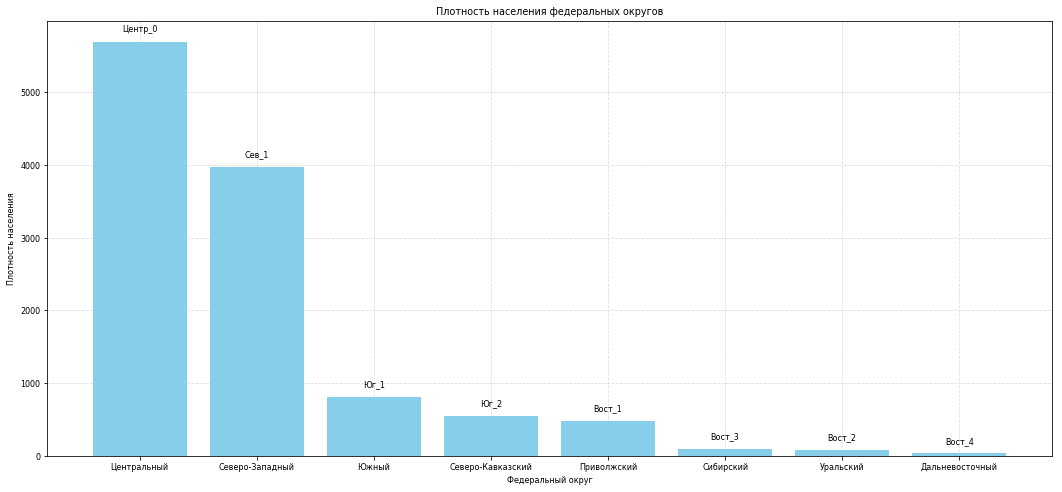

In [87]:
df = df.sort_values('Плотность населения чел/км²', ascending=False)

myplot(df.index, df['Плотность населения чел/км²'],
       'Плотность населения федеральных округов', 
       'Федеральный округ', 'Плотность населения', rotation=0,
        name = 'federal_district_density', text=df['Rang from center'].tolist())

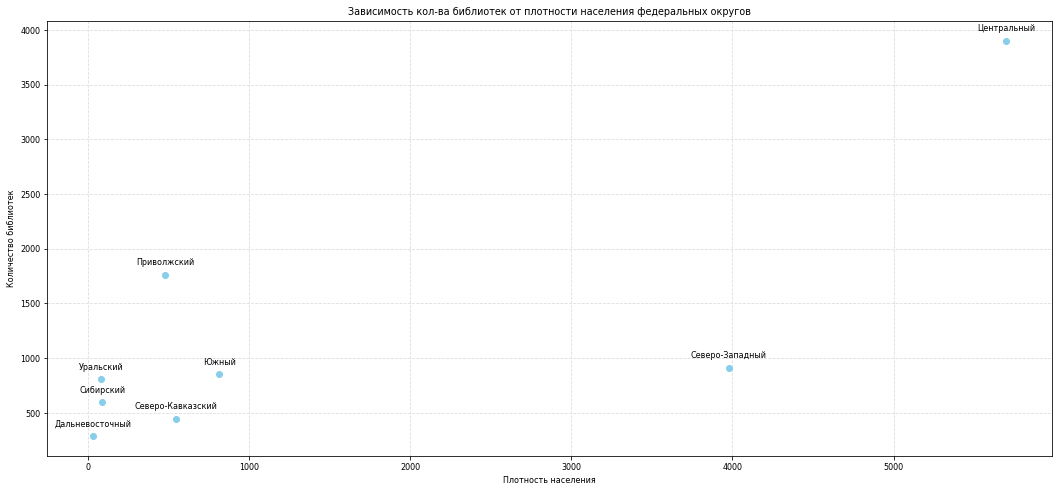

In [88]:
myplot(df['Плотность населения чел/км²'], df['N_libr'],
       'Зависимость кол-ва библиотек от плотности населения федеральных округов', 
       'Плотность населения', 'Количество библиотек', rotation=0,
        name = 'federal_nlibr_density', type_='scatter', text=df.index.tolist())

In [89]:
df[['N_libr', 'Плотность населения чел/км²']].corr()

,N_libr,Плотность населения чел/км²
N_libr,1.000000,0.775584
Плотность населения чел/км²,0.775584,1.000000


### Зависимость от численности населения

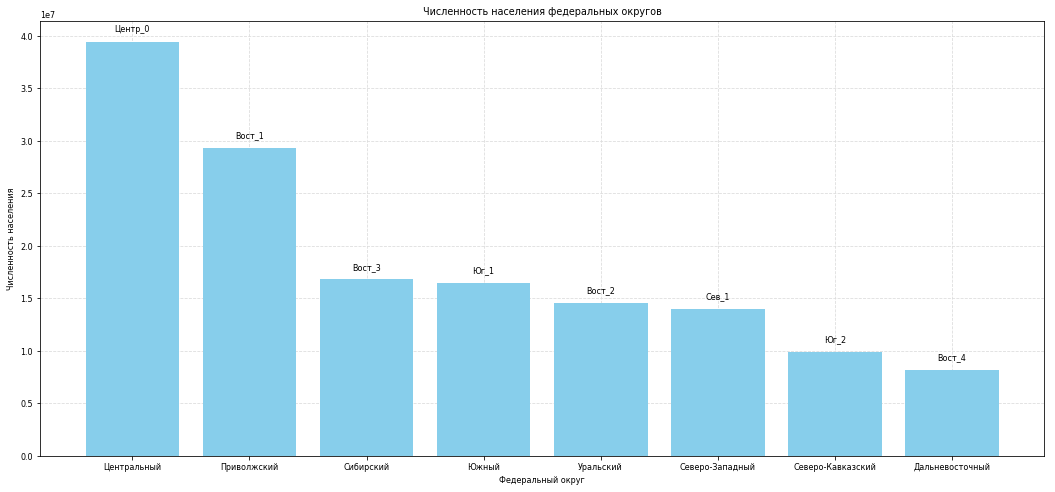

In [90]:
df = df.sort_values('Население. человек', ascending=False)

myplot(df.index, df['Население. человек'],
       'Численность населения федеральных округов', 
       'Федеральный округ', 'Численность населения', rotation=0,
        name = 'federal_district_npeople', text=df['Rang from center'].tolist())

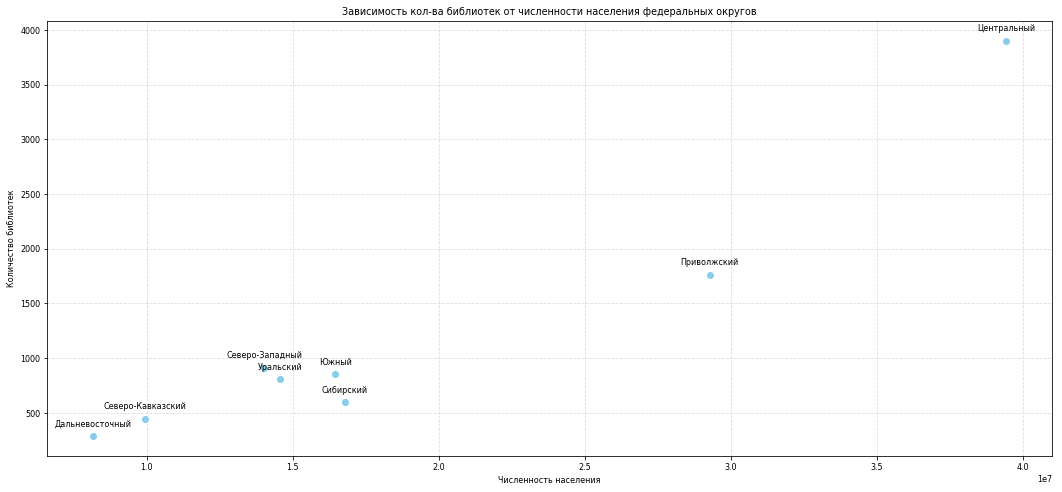

In [91]:
myplot(df['Население. человек'], df['N_libr'],
       'Зависимость кол-ва библиотек от численности населения федеральных округов', 
        'Численность населения', 'Количество библиотек', rotation=0,
        name = 'federal_nlibr_npeople', type_='scatter', text=df.index.tolist())

In [92]:
df[['N_libr', 'Население. человек']].corr()

,N_libr,Население. человек
N_libr,1.000000,0.954811
Население. человек,0.954811,1.000000


### Учебные заведения

In [106]:
data_edu = pd.read_csv("/Users/Stoneberry/Desktop/papers/master/Образования.csv", sep=",")

In [107]:
index_region_edu = region_detector(data_edu, changes, ['Местоположение'])

In [108]:
reg_num = Counter(index_region_edu)

In [109]:
region_data['N_edu'] = [reg_num[name] for name in region_data.index]

In [110]:
df = region_data[['federal_district', 'N_libr', 'Население. человек', 
                  'Площадь км²', 'Плотность населения чел/км²', 'N_district', 'N_edu']]
df = df.groupby('federal_district').sum()

df["Rang from center"] = ['Вост_4', 'Вост_1', 'Сев_1', 'Юг_2', 'Вост_3', 'Вост_2', 'Центр_0', 'Юг_1']

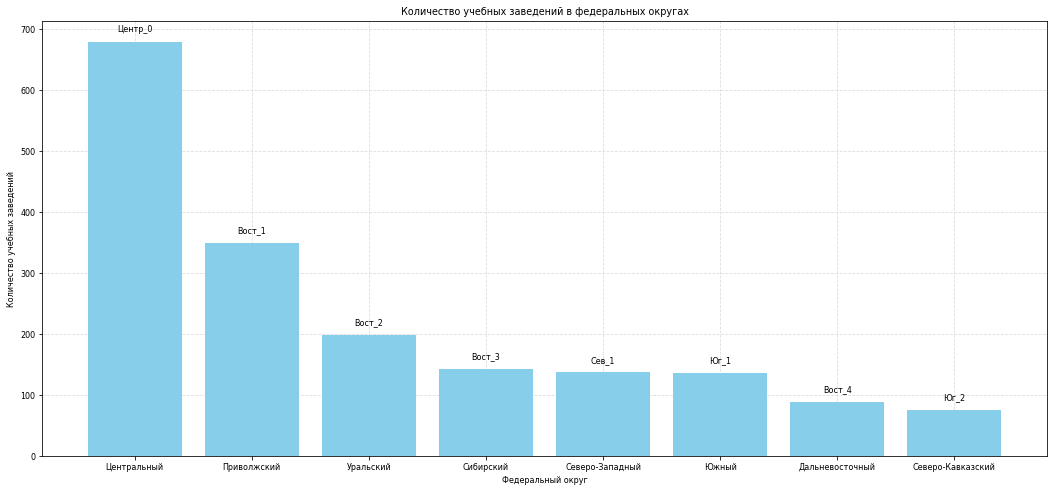

In [111]:
df = df.sort_values('N_edu', ascending=False)

myplot(df.index, df['N_edu'],
       'Количество учебных заведений в федеральных округах', 
       'Федеральный округ', 'Количество учебных заведений', rotation=0,
        text=df['Rang from center'].tolist(),
        name = 'feddistrict_nedu')

### Кол-во библиотек & Кол-во учебных заведений

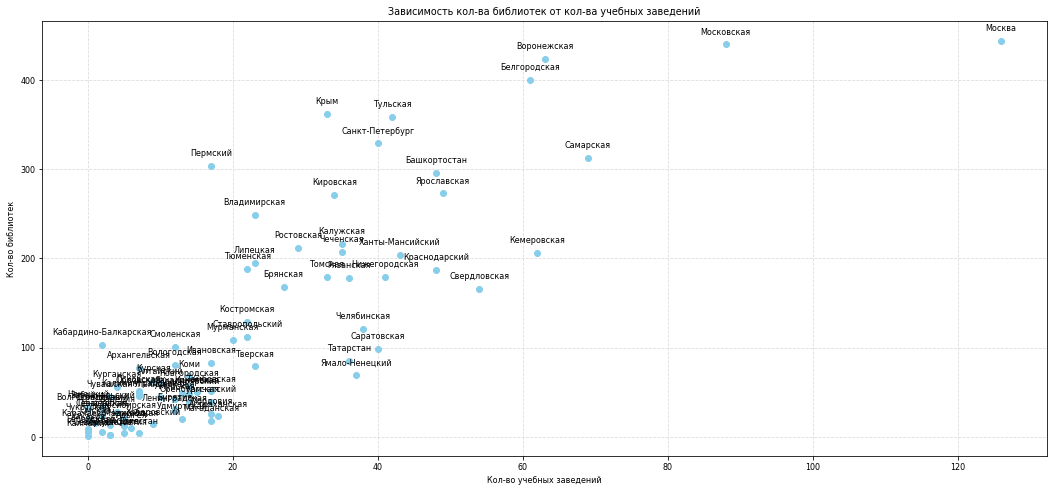

In [112]:
myplot(region_data['N_edu'], region_data['N_libr'],
       'Зависимость кол-ва библиотек от кол-ва учебных заведений', 
        'Кол-во учебных заведений', 'Кол-во библиотек', rotation=0,
        name = 'nlibr_nedu', type_='scatter', text=region_data.index.tolist())

In [113]:
region_data[['N_libr', 'N_edu']].corr()

,N_libr,N_edu
N_libr,1.000000,0.844707
N_edu,0.844707,1.000000


In [114]:
df1 = region_data.drop('Москва', axis=0)
df1[['N_libr', 'N_edu']].corr()

,N_libr,N_edu
N_libr,1.000000,0.842513
N_edu,0.842513,1.000000


По регионам 

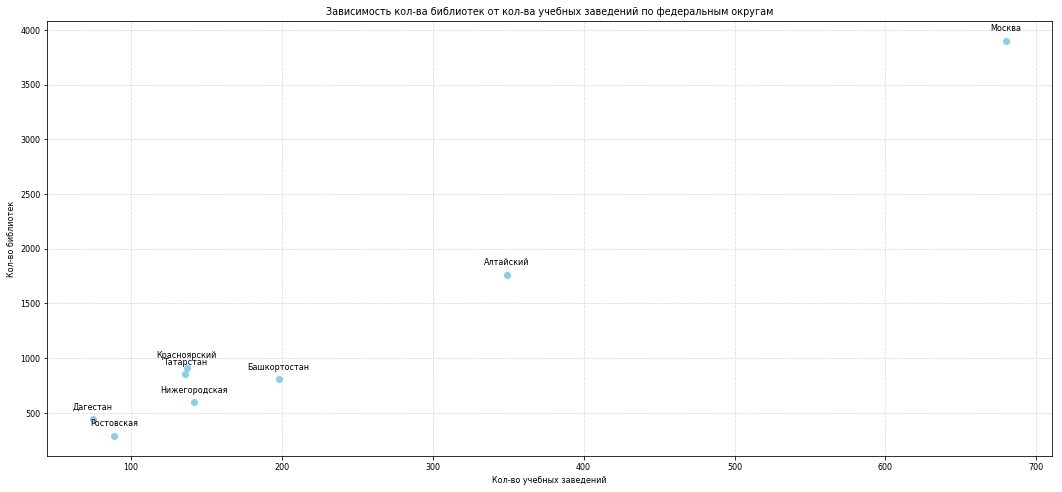

In [115]:
myplot(df['N_edu'], df['N_libr'],
       'Зависимость кол-ва библиотек от кол-ва учебных заведений по федеральным округам', 
        'Кол-во учебных заведений', 'Кол-во библиотек', rotation=0,
        name = 'nlibr_nedu_federal', type_='scatter', text=region_data.index.tolist())

In [116]:
df[['N_libr', 'N_edu']].corr()

,N_libr,N_edu
N_libr,1.000000,0.989407
N_edu,0.989407,1.000000


# Определение районов

In [243]:
def area_detector(data, changes, region_area, columns):
  
    index_area = []
    occupancy = {}

    for index in data.index:
        
        region = data['Регион'][index]
        adr = data['Адрес'][index]
        area = False
        
        if region not in occupancy:
            occupancy[region] = defaultdict(int)
#             for ar in region_area[region]:
#                 occupancy

        if isinstance(adr, str):
            if adr in changes: area = changes[adr]
            else:
                place = adr.split(',')
                for part in place:
                    part = part.split(' ')
                    if part[0] in ('р-н', 'г'):
                        area = part[1]  
        else:
            for name in columns:
                place = data[name][index]
                if 'район' in place:
                    area = re.sub(' район', '', place)
                elif place in changes:
                    area = changes[place]
                if area: break
                        
            if not area:
                place = re.sub('(?:  г|^Г)ородской округ ?', '', place)
                area = re.sub('(?:  г|^Г)ород ?', '', place)
     
        index_area.append(area)
        occupancy[region][area] += 1
        if area not in region_area[region]:
            region_area[region].append(area)
      
    return index_reg, region_area, occupancy

In [244]:
place_area = {'Сосновый Бор': 'Ломоносовский', 'Владивосток': 'Владивостокский',
            'Таганрог': 'Неклиновский', 'Александровск': 'Александровский',
            'Сочи': 'город-курорт Сочи', 'Новороссийск': 'город Новороссийск',
            'Северодвинск': 'город Северодвинск', 'Вилючинск': 'Вилючинский',
            'Полярный': 'Александровск'}

In [249]:
index_reg, region_area, occupancy = area_detector(data, place_area, region_area, ('Подчинение', 'Местоположение'))
occupancy['Тыва'] = {}

In [250]:
data['Район'] = index_reg

### Зависисмость от кол-ва районов в регионе

In [263]:
region_data['District'] = [region_area[name] for name in region_data.index]
region_data['N_district'] = region_data['District'].apply(len)

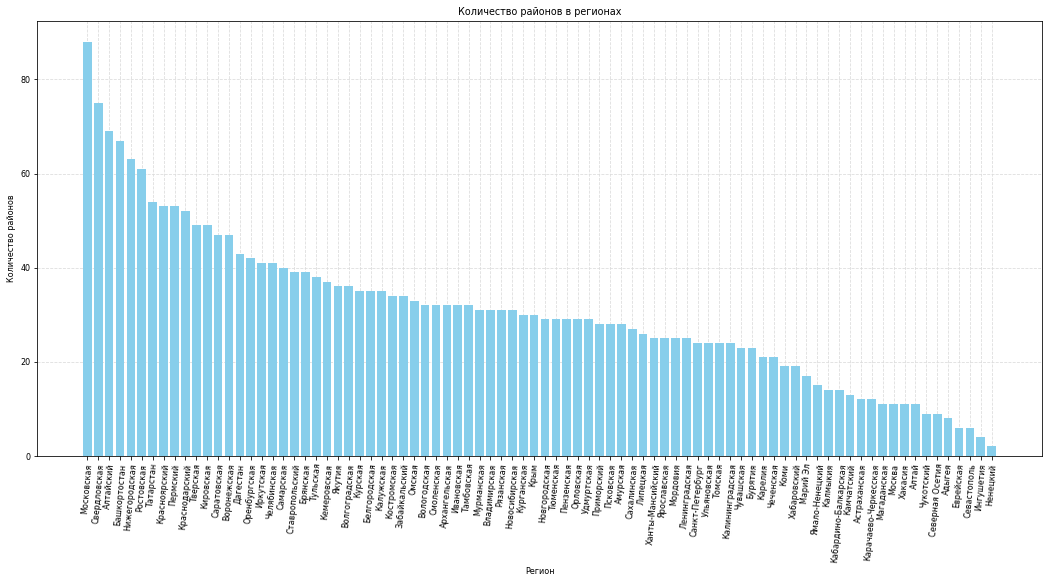

In [264]:
region_data = region_data.sort_values('N_district', ascending=False)

myplot(region_data.index, region_data['N_district'],
       'Количество районов в регионах', 
       'Регион', 'Количество районов', rotation=85,
        name = 'region_ndistricts')

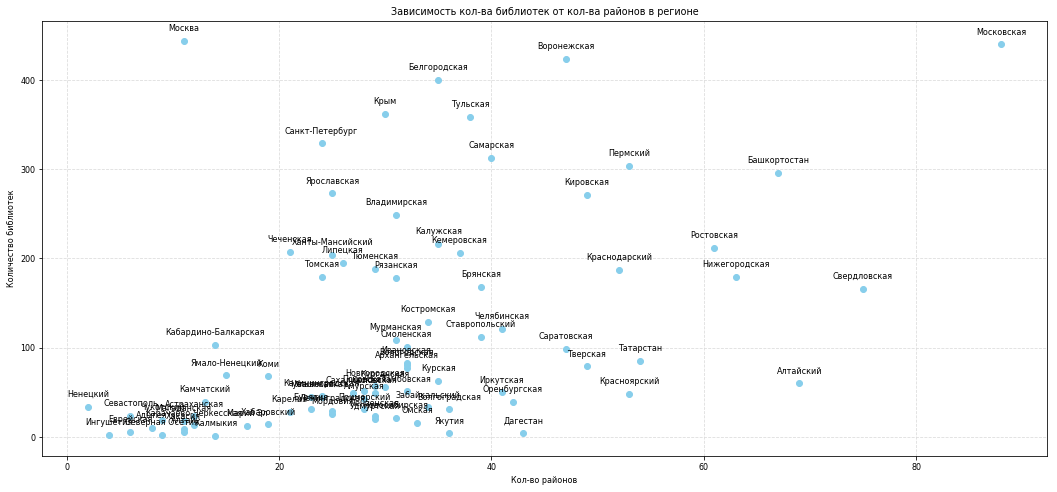

In [265]:
myplot(region_data['N_district'], region_data['N_libr'],
       'Зависимость кол-ва библиотек от кол-ва районов в регионе', 
        'Кол-во районов', 'Количество библиотек', rotation=0,
        name = 'nlibr_nareas', type_='scatter', text=region_data.index.tolist())

In [266]:
region_data[['N_libr', 'N_district']].corr()

,N_libr,N_district
N_libr,1.000000,0.434539
N_district,0.434539,1.000000


По федеральным округам

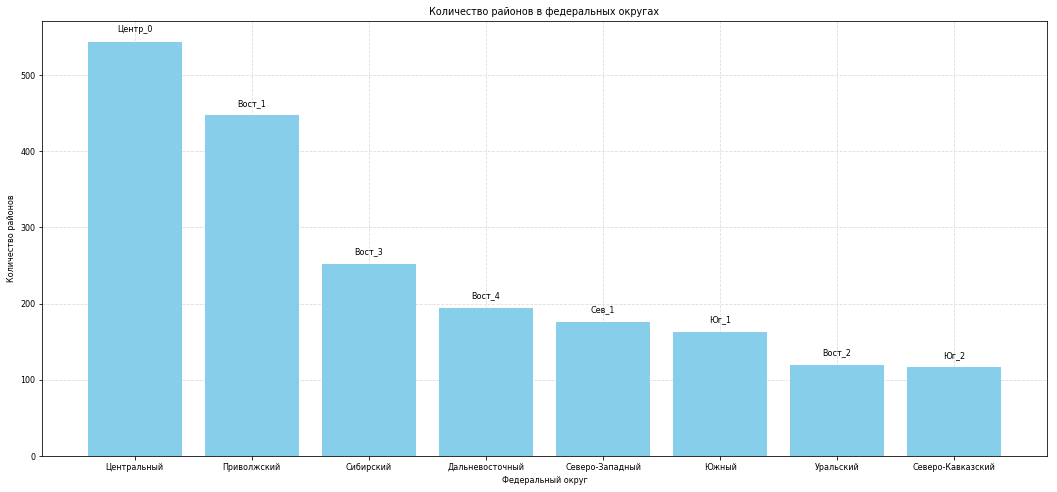

In [267]:
df = df.sort_values('N_district', ascending=False)

myplot(df.index, df['N_district'],
       'Количество районов в федеральных округах', 
       'Федеральный округ', 'Количество районов', rotation=0,
        text=df['Rang from center'].tolist(),
        name = 'feddistrict_ndistricts')

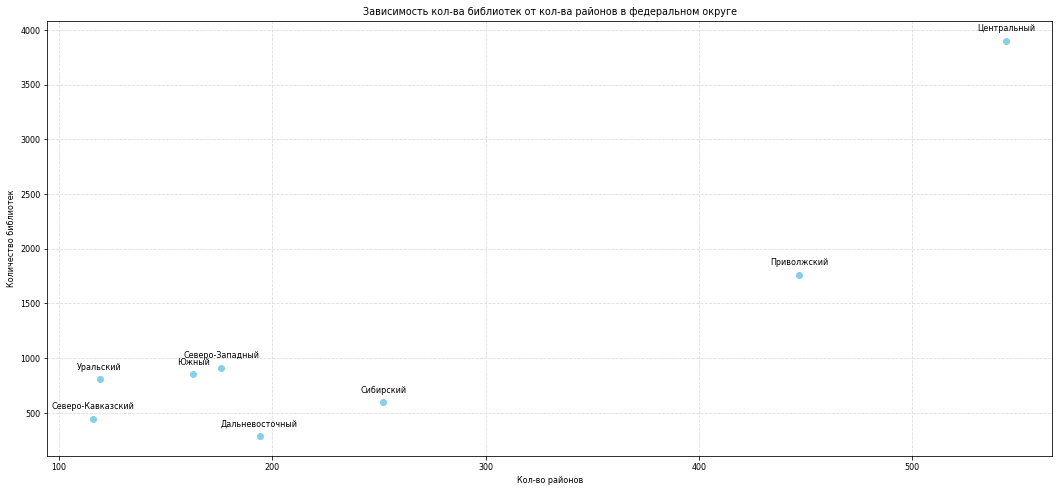

In [268]:
myplot(df['N_district'], df['N_libr'],
       'Зависимость кол-ва библиотек от кол-ва районов в федеральном округе', 
        'Кол-во районов', 'Количество библиотек', rotation=0,
        name = 'nlibr_ndistricts', type_='scatter', text=df.index.tolist())

In [269]:
df[['N_libr', 'N_district']].corr()

,N_libr,N_district
N_libr,1.00000,0.88392
N_district,0.88392,1.00000


## Заполненность

In [251]:
for region in region_area:
    for area in region_area[region]:
        if area not in occupancy[region]:
            occupancy[region][area] = 0

In [254]:
reg_ratio = []

for reg in region_data.index:
    
    n_reg = len(occupancy[reg])
    n_full = [area for area in occupancy[reg] if occupancy[reg][area] != 0]
    n_full = len(n_full)
    reg_ratio.append(np.round(n_full/n_reg * 100))

In [255]:
region_data['Reg_ratio'] = reg_ratio

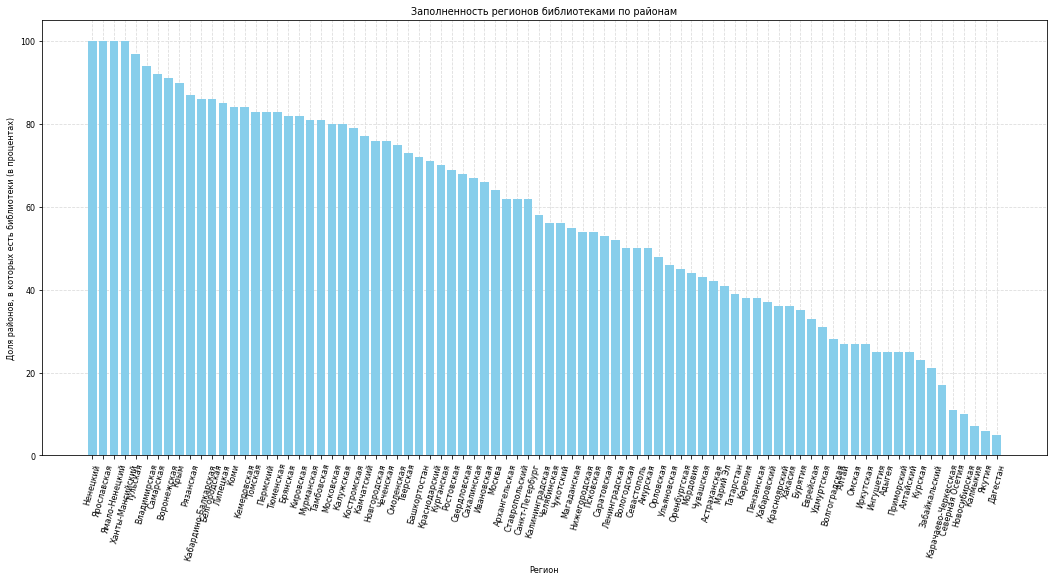

In [260]:
region_data = region_data.sort_values('Reg_ratio', ascending=False)

myplot(region_data.index, region_data['Reg_ratio'],
       'Заполненность регионов библиотеками по районам', 
       'Регион', 'Доля районов, в которых есть библиотеки (в процентах)', rotation=75,
        name = 'ratio_for_region')

## Заполненность & Кол-во районов

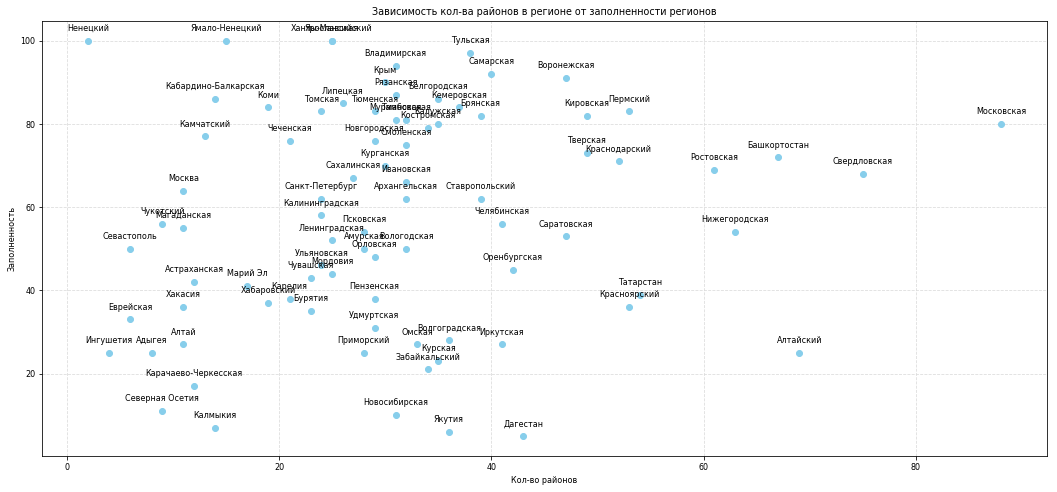

In [284]:
myplot(region_data['N_district'], region_data['Reg_ratio'],
       'Зависимость кол-ва районов в регионе от заполненности регионов', 
        'Кол-во районов', 'Заполненность', rotation=70,
        name = 'naer_reg_ratio', type_='scatter', text=region_data.index.tolist())

In [286]:
region_data[['Reg_ratio', 'N_district']].corr()

,Reg_ratio,N_district
Reg_ratio,1.000000,0.149072
N_district,0.149072,1.000000


По федеральным округам

In [278]:
df = region_data[['federal_district', 'N_libr', 'Население. человек', 
                  'Площадь км²', 'Плотность населения чел/км²', 'N_district', 'Reg_ratio']]
df = df.groupby('federal_district').sum()

df["Rang from center"] = ['Вост_4', 'Вост_1', 'Сев_1', 'Юг_2', 'Вост_3', 'Вост_2', 'Центр_0', 'Юг_1']

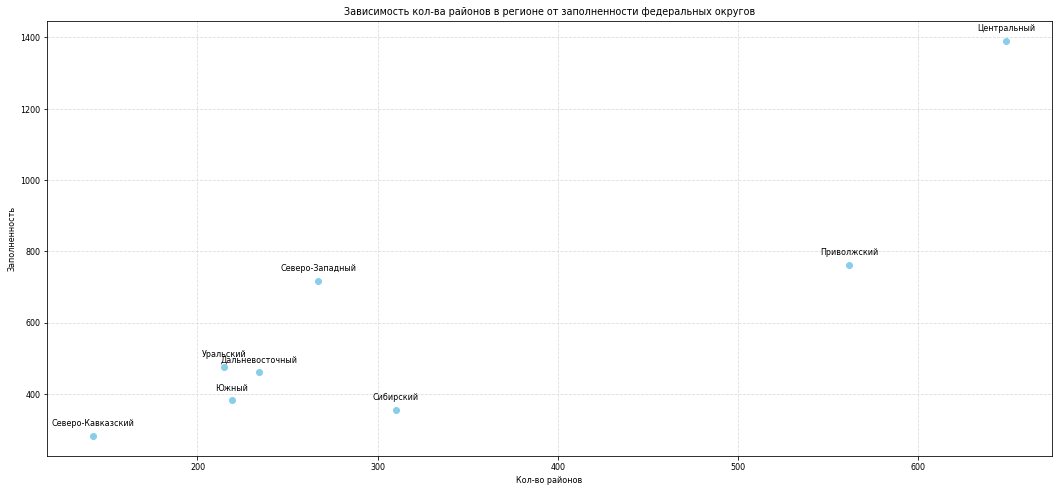

In [290]:
myplot(df['N_district'], df['Reg_ratio'],
       'Зависимость кол-ва районов в регионе от заполненности федеральных округов', 
        'Кол-во районов', 'Заполненность', rotation=70,
        name = 'fed_reg_ratio', type_='scatter', text=df.index.tolist())

In [282]:
df[['Reg_ratio', 'N_district']].corr()

,Reg_ratio,N_district
Reg_ratio,1.000000,0.873523
N_district,0.873523,1.000000


### Заполненность & Плотность населения

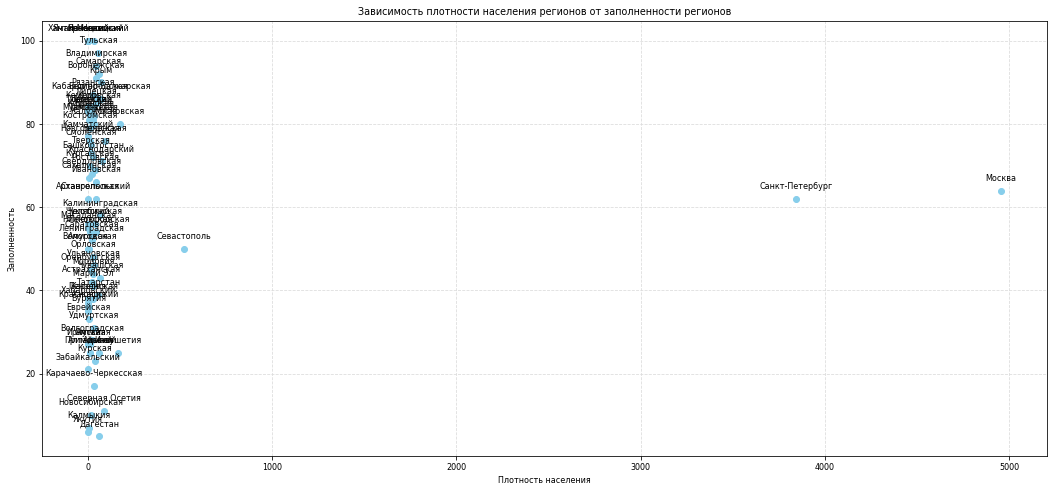

In [294]:
myplot(region_data['Плотность населения чел/км²'], region_data['Reg_ratio'],
       'Зависимость плотности населения регионов от заполненности регионов', 
        'Плотность населения', 'Заполненность', rotation=70,
        name = 'density_reg_ratio', type_='scatter', text=region_data.index.tolist())

Занятно, что отедлились федеральные субъекты

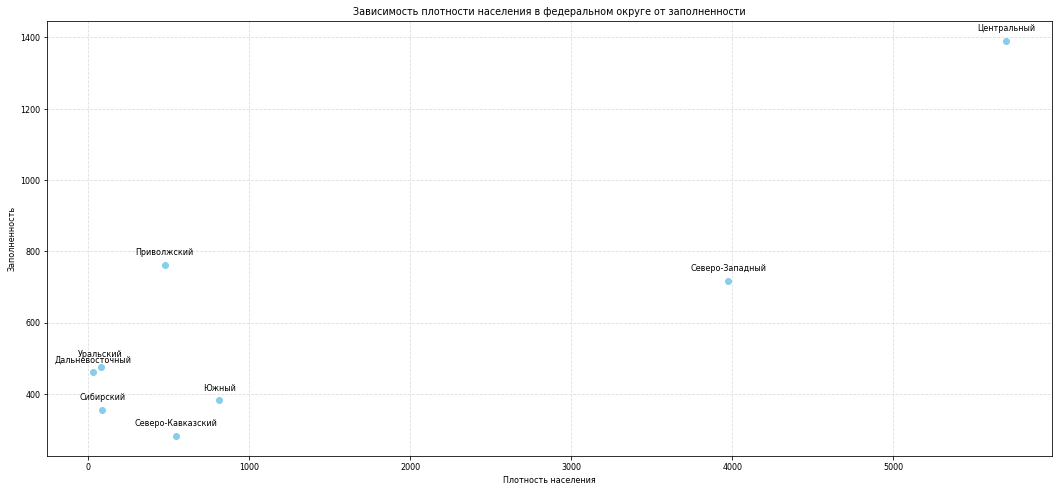

In [301]:
myplot(df['Плотность населения чел/км²'], df['Reg_ratio'], 
       'Зависимость плотности населения в федеральном округе от заполненности', 
        'Плотность населения', 'Заполненность', rotation=70,
        name = 'fed_density_ratio', type_='scatter', text=df.index.tolist())

## Заполненность & Численность

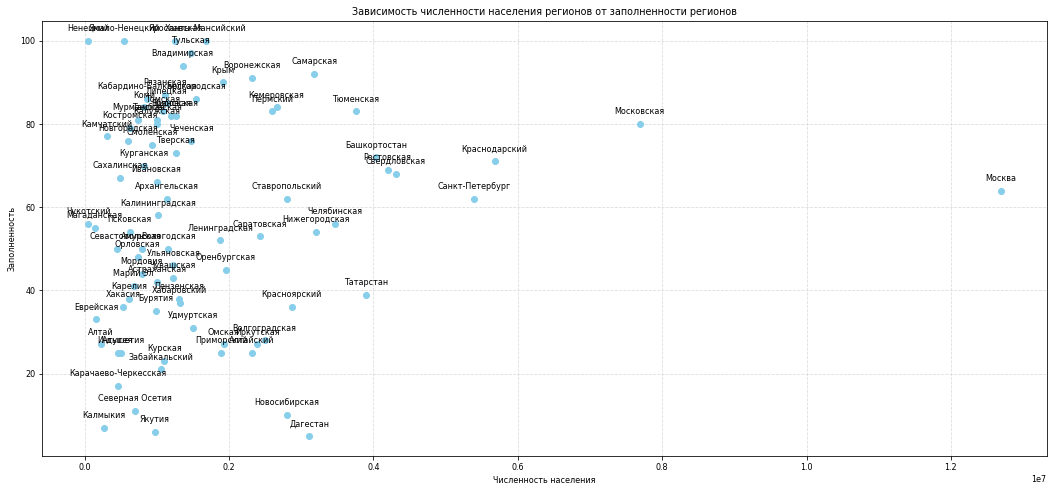

In [300]:
myplot(region_data['Население. человек'], region_data['Reg_ratio'],
       'Зависимость численности населения регионов от заполненности регионов', 
        'Численность населения', 'Заполненность', rotation=70,
        name = 'npeople_reg_ratio', type_='scatter', text=region_data.index.tolist())

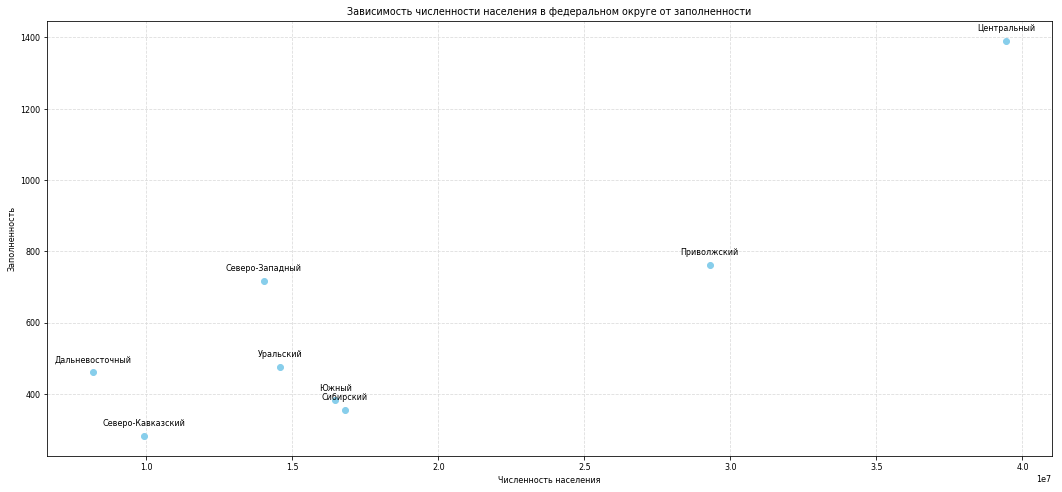

In [302]:
myplot(df['Население. человек'], df['Reg_ratio'], 
       'Зависимость численности населения в федеральном округе от заполненности', 
        'Численность населения', 'Заполненность', rotation=70,
        name = 'fed_npeople_ratio', type_='scatter', text=df.index.tolist())

In [304]:
df[['Население. человек', 'Reg_ratio']].corr()

,Население. человек,Reg_ratio
Население. человек,1.000000,0.876262
Reg_ratio,0.876262,1.000000


### Красноярский край

In [234]:
region_area['Красноярский']

['Абанский',
 'Ачинский',
 'Балахтинский',
 'Березовский',
 'Бирилюсский',
 'Боготольский',
 'Богучанский',
 'Большемуртинский',
 'Большеулуйский',
 'Дзержинский',
 'Емельяновский',
 'Енисейский',
 'Ермаковский',
 'Идринский',
 'Иланский',
 'Ирбейский',
 'Казачинский',
 'Канский',
 'Каратузский',
 'Кежемский',
 'Козульский',
 'Краснотуранский',
 'Курагинский',
 'Манский',
 'Минусинский',
 'Мотыгинский',
 'Назаровский',
 'Нижнеингашский',
 'Новоселовский',
 'Партизанский',
 'Пировский',
 'Рыбинский',
 'Саянский',
 'Северо-Енисейский',
 'Сухобузимский',
 'Таймырский Долгано-Ненецкий',
 'Тасеевский',
 'Туруханский',
 'Тюхтетский',
 'Ужурский',
 'Уярский',
 'Шарыповский',
 'Шушенский',
 'Эвенкийский',
 'Саяногорск',
 'Лесосибирск',
 'Красноярск',
 'Канск',
 'ЗАТО Железногорск',
 'Назарово',
 'Бородино',
 'Шарыпово',
 'Дудинка']

#  Сохраняем

In [296]:
data2 = data[['Название', 'Местоположение', 'На карте', 'Номер',
              'Адрес электронной почты', 'Адрес сайта', 'Описание',
              'Принадлежность', 'Подчинение', 'Тэги', 'Изображение',
              'Регион', 'Район']]

In [297]:
data2.to_csv("/Users/Stoneberry/Desktop/papers/master/data from names/database2.csv", sep=";")
data_edu.to_csv("/Users/Stoneberry/Desktop/papers/master/Образование2.csv", sep=";")
region_data.to_csv("/Users/Stoneberry/Desktop/papers/master/reg_stat_data.csv", sep=";")